# Project 03
* Kaggle에서 진행했던 대회의 데이터(House Price Prediction)를 가지고 성능을 올려보자.
* [2019 ML month 2nd baseline 커널](https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline)을 베이스라인으로 작성했다.

### 사용 라이브러리
* `xgboost` : 익스트림 그레이디언트 부스팅(Extreme Gradient Boosting)(version_1.7.5)
* `lightgbm` : Light Gradient-Boosting Machine(version_3.3.5)
* `missingno ` : 결측치 확인을 위한 라이브러리(version_0.5.2)

In [2]:
import warnings
warnings.filterwarnings("ignore") # 경고 무시

import os
from os.path import join 

import pandas as pd
import numpy as np

import missingno as msno # 결측치 확인

from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.model_selection import KFold, cross_val_score # 검증
from sklearn.metrics import mean_squared_error #검증
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb # 회귀 모델
import lightgbm as lgb  # 회귀 모델

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

데이터 경로 설정

In [3]:
## Kaggle의 커널 내의 경로
# train_data_path = join('../input', 'train.csv')
# sub_data_path = join('../input', 'test.csv')

dir = os.getcwd()+'/House_Price_Prediction/'

train_data_path = join(dir, 'train.csv')
sub_data_path = join(dir, 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

* `sub_data`는 제출용 데이터로 정답데이터인 집값 컬럼이 없다.
* 따라서, `sub_data`의 집값을 잘 예측해보자!

In [4]:
train_data = pd.read_csv(train_data_path)
sub_data = pd.read_csv(sub_data_path)

print('train data dim : {}'.format(train_data.shape))
print('sub data dim : {}'.format(sub_data.shape))

train data dim : (15035, 21)
sub data dim : (6555, 20)


* `train_data`의 집값 컬럼을 `label`로 저장하고 컬럼을 지운다.
* 제출용 데이터와 합쳐서 전처리를 진행해보자~

In [5]:
label = train_data['price']
del train_data['price']

In [6]:
train_len = len(train_data)
data = pd.concat((train_data, sub_data), axis=0)
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 데이터 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다. 결측치가 있다면 해당부분이 하얗게 나온다.

<Axes: >

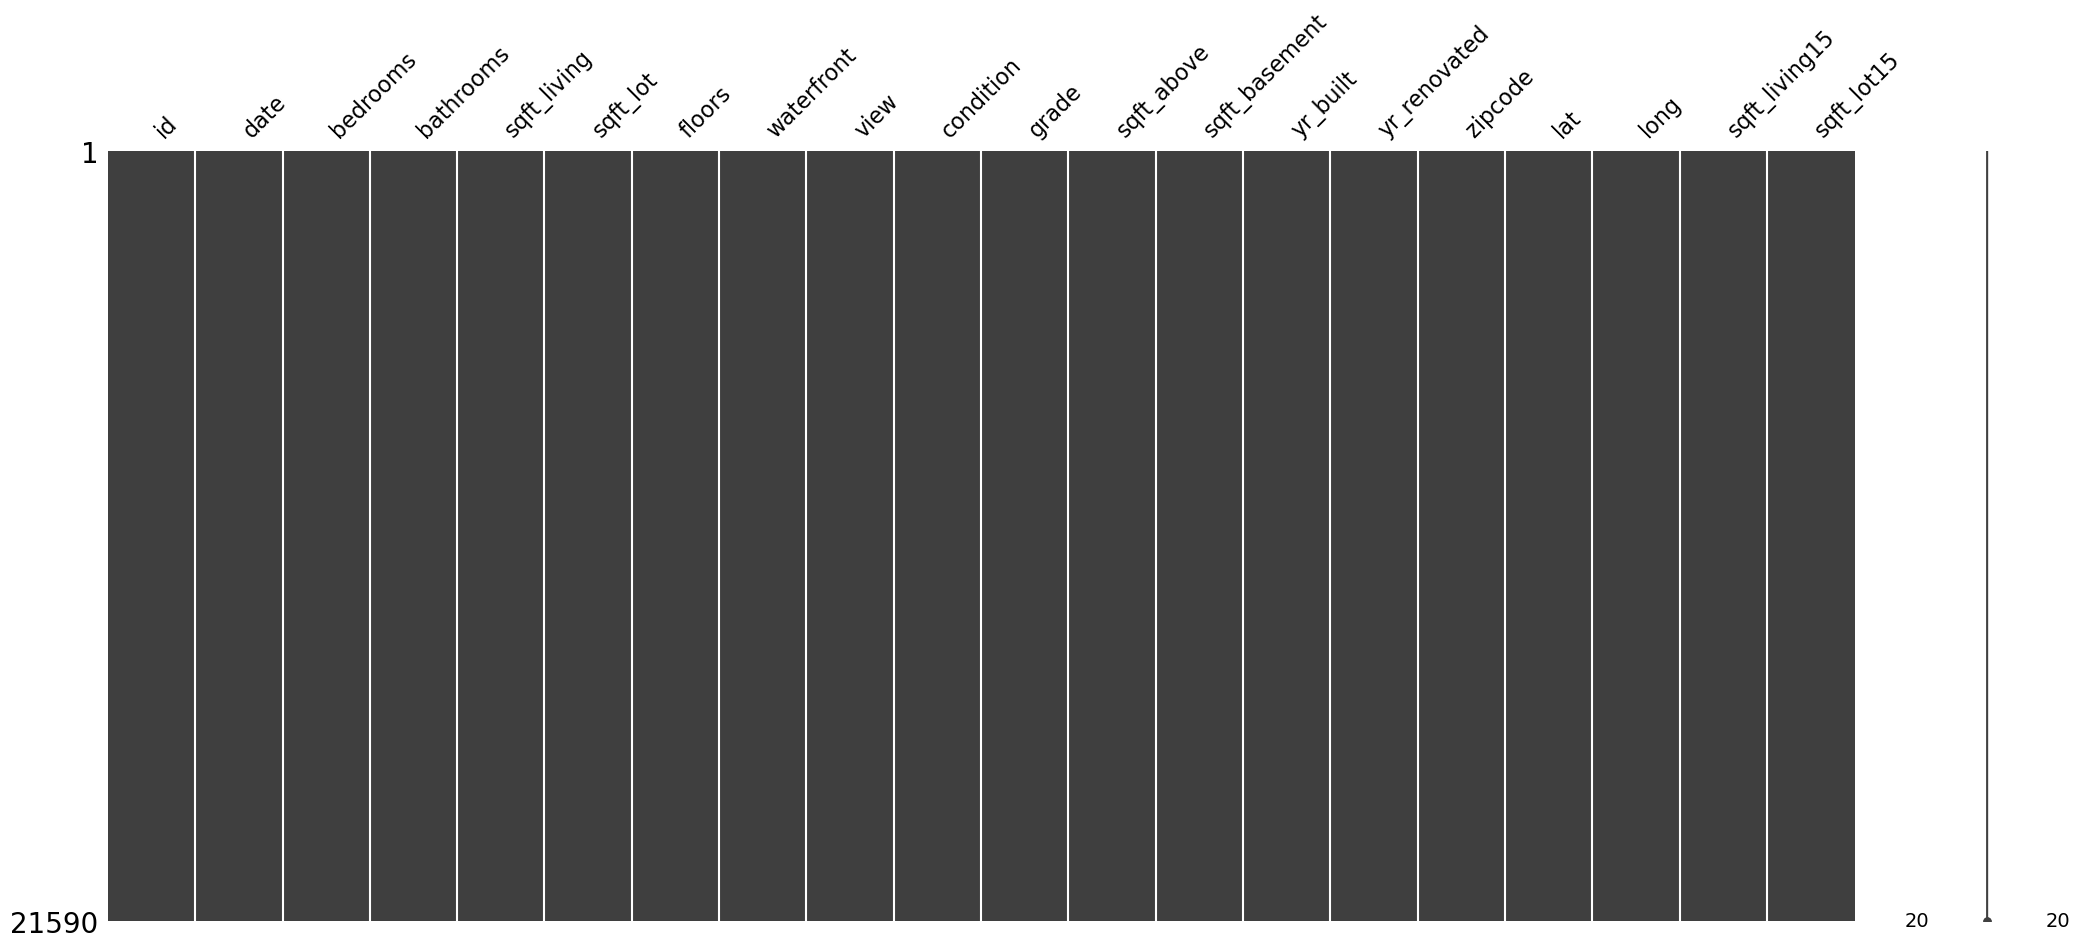

In [7]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [8]:
for c in data.columns:
    nul_data_bool = pd.isnull(data[c])
    print('{} : {}'.format(c, len(data.loc[nul_data_bool, c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.(	20141013T000000 -> 201410 )

In [9]:
sub_id = data['id'][train_len:]
del data['id']

In [10]:
data['date_ym'] = data['date'].apply(lambda x : str(x[:6])).astype(int)
del data['date']
data

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_ym
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,201410
1,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,201502
2,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,201502
3,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,201406
4,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,201501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6550,4,2.75,2770,3852,2.0,0,0,3,8,2770,0,2014,0,98178,47.5001,-122.232,1810,5641,201410
6551,3,2.25,1190,1200,3.0,0,0,3,8,1190,0,2008,0,98103,47.6542,-122.346,1180,1224,201504
6552,5,3.75,4470,8088,2.0,0,0,3,11,4470,0,2008,0,98004,47.6321,-122.200,2780,8964,201410
6553,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230,201501


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

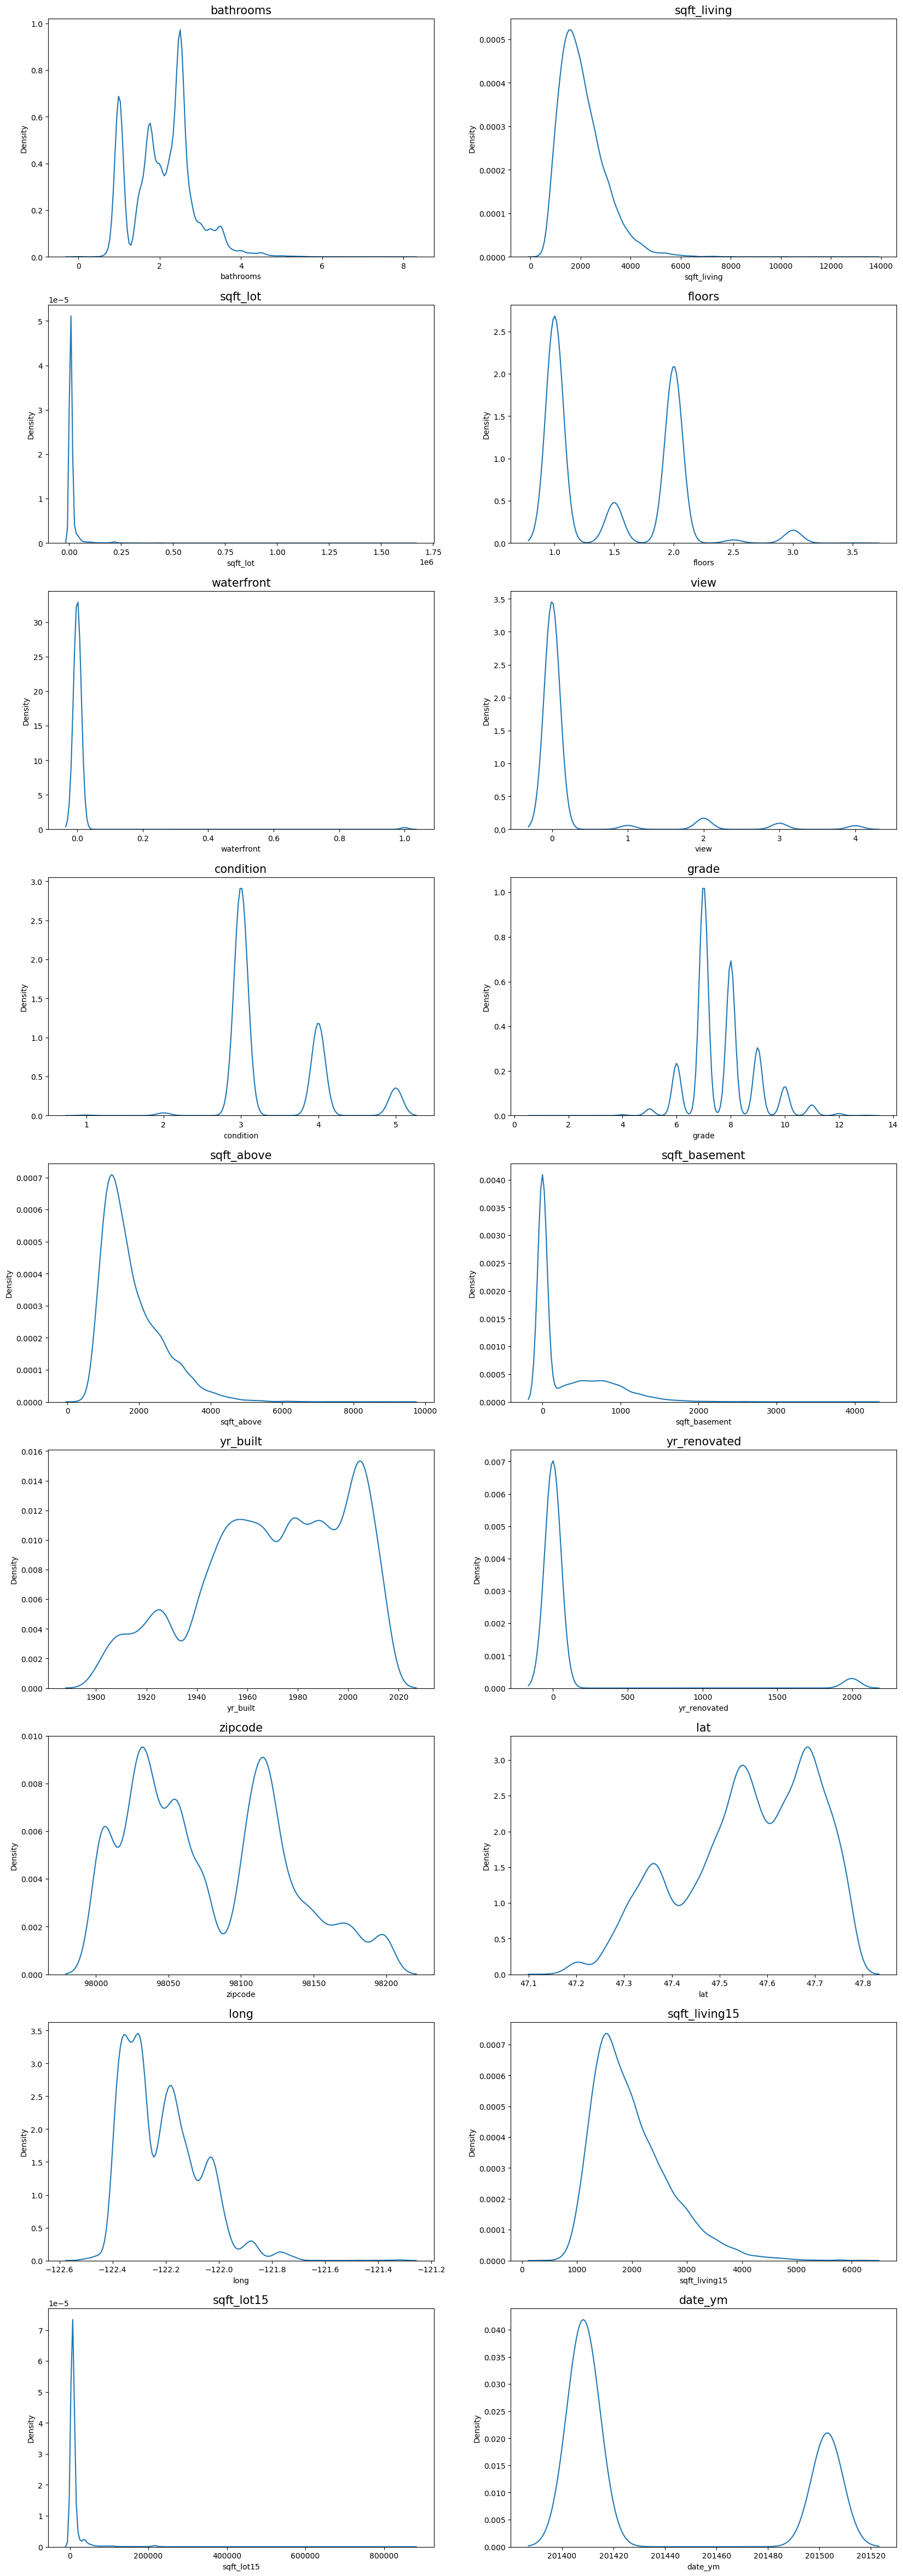

In [11]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', \
    'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values) 

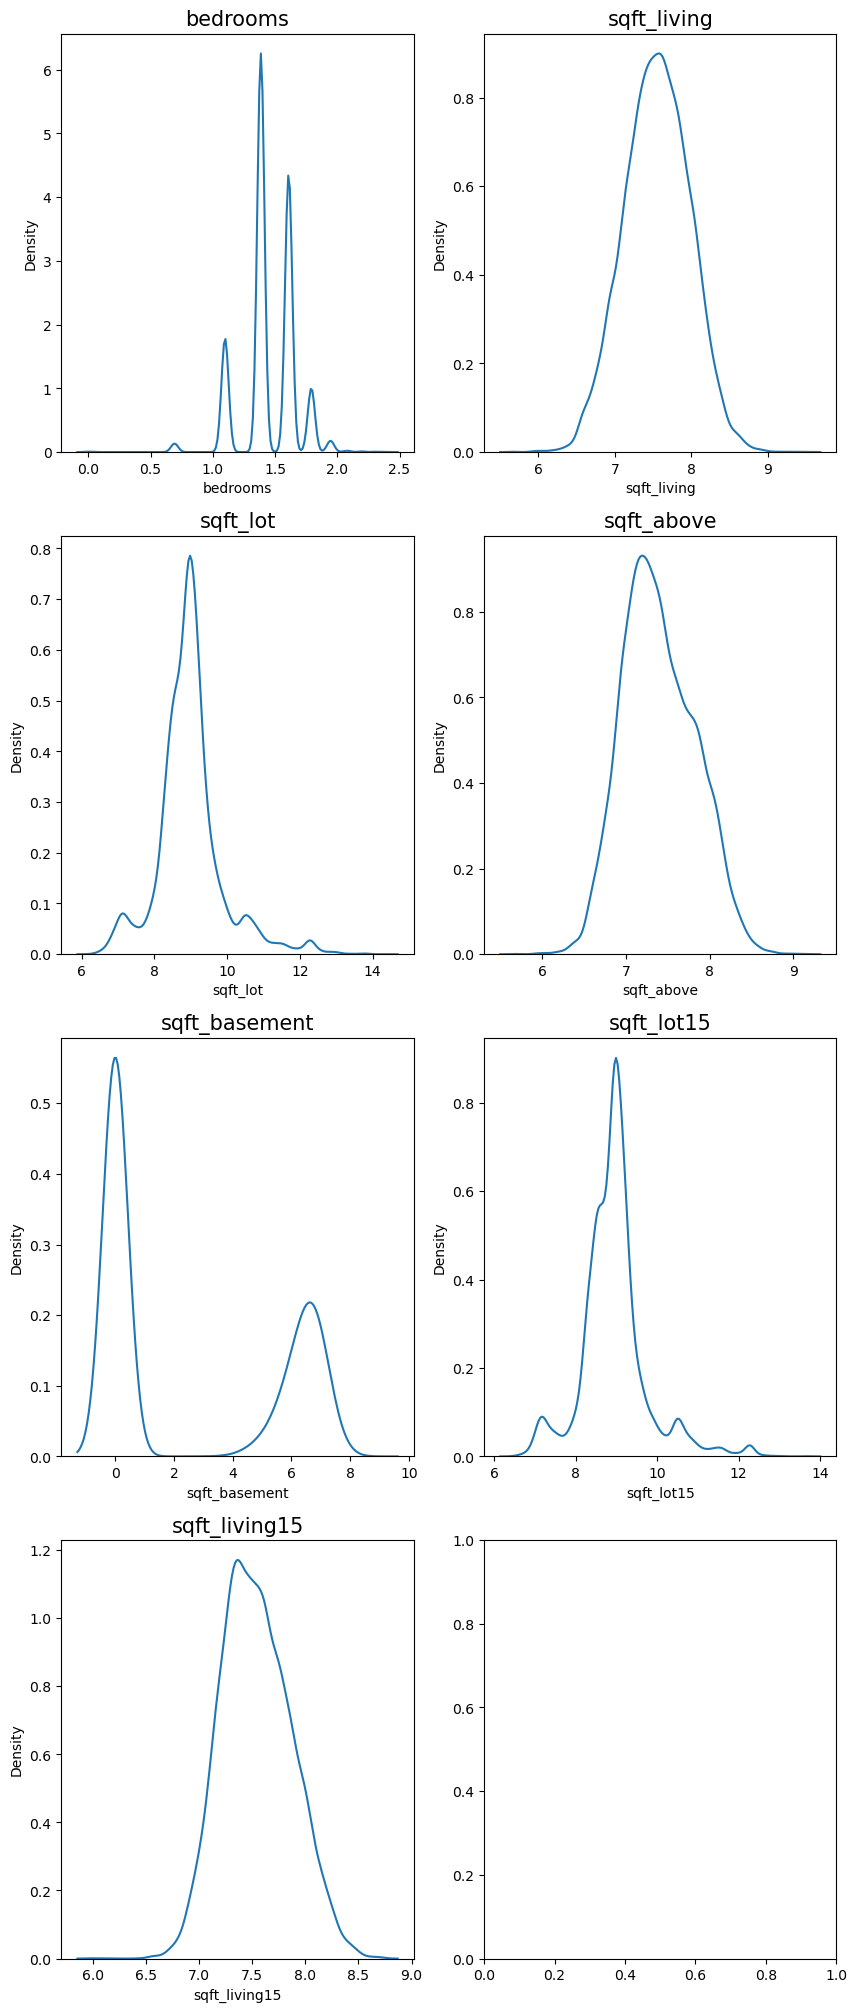

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(10, 25))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



* 어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

### `label` 데이터 분포 확인

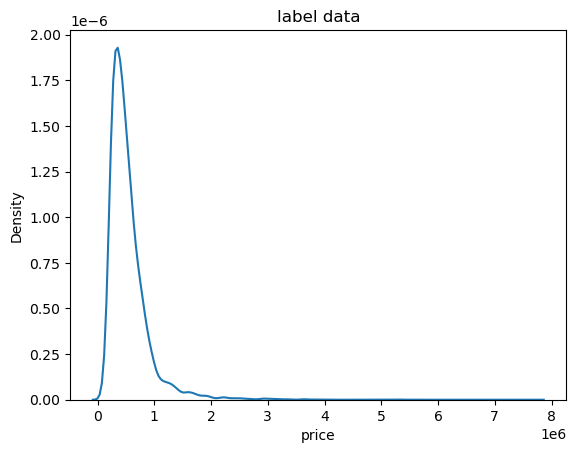

In [14]:
plt.figure()
sns.kdeplot(label)
plt.title('label data')
plt.show()

* log 스케일로 분포를 재조정한다.

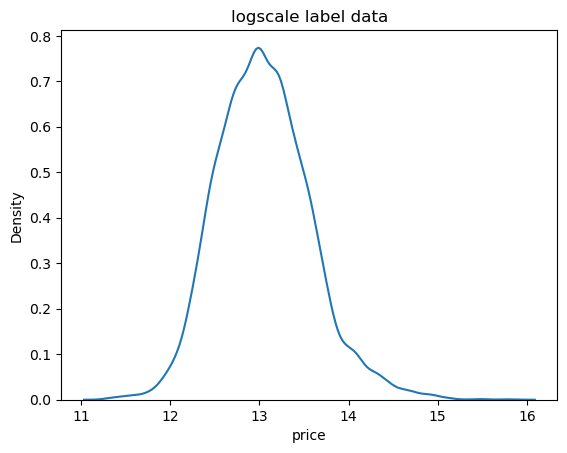

In [15]:
label_logscale = np.log1p(label)

sns.kdeplot(label_logscale)
plt.title('logscale label data')
plt.show()

In [16]:
train_data = data.iloc[:train_len, :]
sub_data = data.iloc[train_len:, :]

## 3. 모델링

### RMSE
Kaggle의 점수를 RMSE로 평가하기에 
`XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor` 네 가지 모델의 성능을 평가하는 함수 


In [17]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test,y_pred))

In [18]:
def get_scores(models, train, y, random_state=42, test_size=0.3):
    df = {} 
    X_train, X_test, y_train, y_test = \
        train_test_split(train, y, test_size=test_size, random_state=random_state)

    for model in models:
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        df[model.__class__.__name__] = rmse(np.expm1(y_test), np.expm1(y_pred))
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

### Grid Search


In [19]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    return results

In [31]:
rand_state = 777
# 모델 정의
gboost = GradientBoostingRegressor(random_state=rand_state)
xgboost = xgb.XGBRegressor(random_state=rand_state)
lightgbm = lgb.LGBMRegressor(random_state=rand_state)
rdforest = RandomForestRegressor(random_state=rand_state)

models = [gboost, xgboost, lightgbm, rdforest]

# 최적의 파라미터 구하기
param_grid_gb = {
'n_estimators': [100, 200, 300],
'learning_rate': [0.01, 0.05, 0.1],
'max_depth': [3, 5, 7],
'min_samples_split': [2, 4, 6],
'min_samples_leaf': [1, 2, 3]
}

param_grid_xgb = {
'n_estimators': [100, 200, 300],
'learning_rate': [0.01, 0.05, 0.1],
'max_depth': [3, 5, 7],
'min_child_weight': [1, 3, 5],
'gamma': [0, 0.1, 0.2]
}

param_grid_lgb = {
'n_estimators': [100, 200, 300],
'learning_rate': [0.01, 0.05, 0.1],
'max_depth': [3, 5, 7],
'num_leaves': [31, 50, 100],
'min_child_samples': [20, 30, 50]
}

param_grid_rf = {
'n_estimators': [100, 200, 300],
'max_depth': [None, 5, 10],
'min_samples_split': [2, 4, 6],
'min_samples_leaf': [1, 2, 3],
'max_features': ['auto', 'sqrt', 'log2']
}
params = [param_grid_gb,param_grid_xgb,param_grid_lgb,param_grid_rf]

best_params = {}
for i in range(len(models)):
    gs_data = my_GridSearch(models[i], train_data, label_logscale, params[i], verbose=2, n_jobs=5)
    best_gs = gs_data[0]
    best_params[models[i]] = {'param_1':best_gs[0], 'param_2':best_gs[1],
                   'param_3':best_gs[2], 'param_4':best_gs[3], 'RMSLE':best_gs[-1]} 
    
best_params
  
    
    

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


KeyboardInterrupt: 

In [ ]:
# 최적으로 찾은 파라미터 입력
rand_state = 1004
gboost = GradientBoostingRegressor(n_estimators=best_params[0,1],
                                   learning_rate=best_params[0,2],
                                   max_depth=best_params[0,3],
                                   min_samples_split=best_params[0,4],
                                   min_samples_leaf=best_params[0,5],
                                   random_state=rand_state)
xgboost = xgb.XGBRegressor(n_estimators=best_params[1,1],
                           learning_rate=best_params[1,2],
                           max_depth=best_params[1,3],
                           min_child_weight=best_params[1,4],
                           gamma=best_params[1,5],
                           random_state=rand_state)
xgboost = lgb.LGBMRegressor(n_estimators=best_params[2,1],
                            learning_rate=best_params[2,2],
                            max_depth=best_params[2,3],
                            num_leaves=best_params[2,4],
                            min_child_samples=best_params[2,5],
                            random_state=rand_state)
gboost = RandomForestRegressor(n_estimators=best_params[3,1],
                               max_depth=best_params[3,2],
                               min_samples_split=best_params[3,3],
                               min_samples_leaf=best_params[3,4],
                               max_features=best_params[3,5],
                               random_state=rand_state)


models = [gboost, xgboost, lightgbm, rdforest]

score = get_scores(models, train_data, label_logscale, random_state=rand_state, test_size=0.3)
score


### Make Submission

훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models ])
    
    return np.mean(predictions, axis=1)

In [ ]:
def save_submission(models, train, y, sub_x, model_name, rmsle):
    
    prediction = AveragingBlending(models, train, y, sub_x)
    
    prediction = np.expm1(prediction)
    
    submission_path = join(dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
rmse_mean = round(np.mean(score['RMSE'])).dtype(str)
save_submission(models, train_data, label_logscale, sub_data, \
    'Average Blending', rmsle=round(np.mean(score['RMSE'])).dtype(str))